# GGL of UNIONS galaxies by AGNs

This notebook performs first measurements of galaxy-galaxy lensing between SDSS AGN and UNIONS 3500 deg^2 catalogs.

In [1]:
%matplotlib inline

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.io import ascii

In [ ]:
import treecorr

## Variables

In [4]:
# Split catalogue into mass bins
n_split = 2

### Output

In [ ]:
output_path = './data_mass_sub'

output_cc_base = 'ggl_all_UNIONS_v1_agn'

### AGN data

In [ ]:
# Path to data
path_to_agn_data = output_path

# AGN catalogue name
agn_cat_fname_base = 'SDSS_SMBH_202206'

# Columns in data
# ra, dec in deg
# logM is log of SMBH mass in M_sol
#names = ['ra', 'dec', 'z', 'logM']

names = ['ra', 'dec', 'z', 'logM', 'w_0', 'w_1']

### UNIONS weak-lensing data

In [ ]:
# Path to data

version = '1.0'

path_to_unions_data = f'{os.environ["HOME"]}/astro/data/UNIONS/v{version}/ShapePipe'
unions_cat_name = f'unions_shapepipe_extended_2022_v{version}.fits'

### Plotting

In [ ]:
# Figure ticks and labels
ticks_size = 15
label_size = 18

### Units

In [11]:
coord_units = 'degrees'
sep_units = 'arcmin'

## Read catalogs

In [ ]:
# Set file names
agn_cat_name_list = []
for idx in range(n_split):
    agn_cat_name = f'{output_path}/{agn_cat_fname_base}_{idx}_n_split_{n_split}.txt'
    agn_cat_name_list.append(agn_cat_name)

In [ ]:
# AGN mass subsamples
data_agn_list = []
for agn_cat_name in agn_cat_name_list:
    data_agn = ascii.read(f'{agn_cat_name}', names=names)
    data_agn_list.append(data_agn)

In [14]:
# UNIONS
hdu_list_unions = fits.open(f'{path_to_unions_data}/{unions_cat_name}')

unions_data = hdu_list_unions[1].data

## Computation of correlation

In [ ]:
theta_min = 0.1
theta_max = 200

TreeCorrConfig = {
    'ra_units': coord_units,
    'dec_units': coord_units,
    'min_sep': theta_min,
    'max_sep': theta_max,
    'sep_units': sep_units,
    'nbins': 10
}

In [ ]:
cat_mass_list = []

for idx in range(len(agn_cat_name_list)):
    data_agn = data_agn_list[idx]
    cat_mass = treecorr.Catalog(
        ra=data_agn['ra'],
        dec=data_agn['dec'],
        w=data_agn[f'w_{idx}'],
        ra_units=coord_units,
        dec_units=coord_units
    )
    cat_mass_list.append(cat_mass)

In [ ]:
cat_unions = treecorr.Catalog(
    ra=unions_data['ra'],
    dec=unions_data['dec'],
    g1=unions_data['e1'],
    g2=unions_data['e2'],
    w=unions_data['w'],
    ra_units=coord_units,
    dec_units=coord_units
)

In [ ]:
ng_list = []
for idx in range(len(agn_cat_name_list)):
    cat_mass = cat_mass_list[idx]
    ng = treecorr.NGCorrelation(TreeCorrConfig)
    print(f'Processing cat mass cat #{idx}')
    ng.process(cat_mass, cat_unions)
    ng_list.append(ng)

In [ ]:
# Write correlation data to files
for idx, ng in enumerate(ng_list):
    out_name = f'{output_path}/{output_cc_base}_{idx}_n_split_{n_split}.fits'
    print(f'Writing GGL correlation function to file {out_name}')
    ng.write(
        out_name,
        rg=None,
        file_type=None,
        precision=None
    )

## Plotting

In [57]:
# Read correlation data file and assign quantities of interest
data_cc_list = []
for idx in range(n_split):
    cc_name = f'{output_path}/{output_cc_base}_{idx}_n_split_{n_split}.fits'
    f = fits.open(cc_name)
    data_cc = f[1].data
    data_cc_list.append(data_cc)

In [ ]:
data_cc_list[0].dtype.names

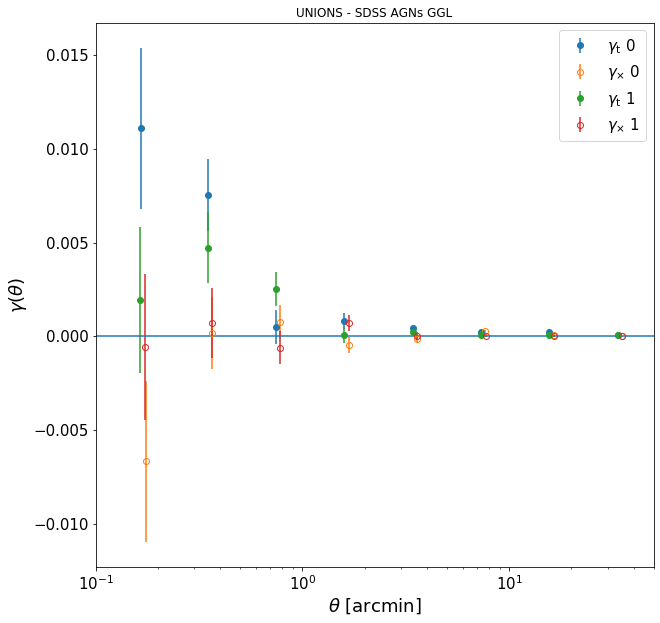

In [76]:
plt.figure(figsize=(10, 10))

fx = 1.05

for idx in range(n_split):
    data_cc = data_cc_list[idx]
    plt.errorbar(
        data_cc['meanr'],
        data_cc['gamT'],
        yerr=data_cc['sigma'],
        fmt='o',
        label=rf'$\gamma_{{\rm t}}$ {idx}')
    
    plt.errorbar(
        data_cc['meanr']*fx,
        data_cc['gamX'],
        yerr=data_cc['sigma'],
        fmt='o',
        markerfacecolor='none',
        label=rf'$\gamma_{{\times}}$ {idx}'
    )
plt.axhline(y=0)

plt.xlabel(rf'$\theta$ [{sep_units}]', fontsize=label_size)
plt.ylabel(r'$\gamma(\theta)$', fontsize=label_size)

plt.xscale("log")
plt.xlim(theta_min, 50)
plt.xticks(fontsize = ticks_size)
plt.yticks(fontsize = ticks_size)
plt.legend(fontsize = ticks_size)
plt.title('UNIONS - SDSS AGNs GGL')

_  = plt.savefig(f'{output_path}/{output_cc_base}.pdf')

In [ ]:
plt.figure(figsize=(10, 10))

fx = [1, 1.05]

col = ['g', 'b']

for idx in range(n_split):
    data_cc = data_cc_list[idx]
    plt.errorbar(
        data_cc['meanr'] * fx[idx],
        data_cc['gamT'],
        yerr=data_cc['sigma'],
        fmt='o',
        c=col[idx],
        label=rf'$\gamma_{{\rm t}}$ {idx}'
    )
    eb = plt.errorbar(
        data_cc['meanr'] * fx[idx],
        -data_cc['gamT'],
        yerr=data_cc['sigma'],
        fmt='s',
        c=col[idx],
    )
    eb[-1][0].set_linestyle('--')

plt.xlabel(rf'$\theta$ [{sep_units}]', fontsize=label_size)
plt.ylabel(r'$\gamma(\theta)$', fontsize=label_size)

plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize = ticks_size)
plt.yticks(fontsize = ticks_size)
plt.legend(fontsize = ticks_size)
plt.title('UNIONS - SDSS AGNs GGL')

_  = plt.savefig(f'{output_path}/{output_cc_base}_log_gt.pdf')

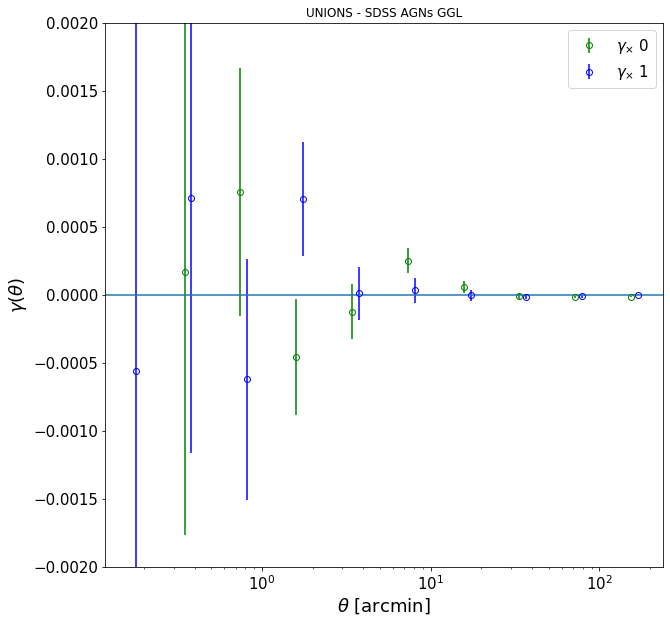

In [93]:
plt.figure(figsize=(10, 10))

fx = [1, 1.1]

col = ['g', 'b']

for idx in range(n_split):
    data_cc = data_cc_list[idx]
    plt.errorbar(
        data_cc['meanr'] * fx[idx],
        data_cc['gamX'],
        yerr=data_cc['sigma'],
        fmt='o',
        markerfacecolor='none',
        c=col[idx],
        label=rf'$\gamma_{{\times}}$ {idx}'
    )

plt.axhline(y=0)

plt.xlabel(rf'$\theta$ [{sep_units}]', fontsize=label_size)
plt.ylabel(r'$\gamma(\theta)$', fontsize=label_size)

plt.xscale('log')
plt.ylim(-0.002, 0.002)
plt.xticks(fontsize = ticks_size)
plt.yticks(fontsize = ticks_size)
plt.legend(fontsize = ticks_size)
plt.title('UNIONS - SDSS AGNs GGL')

_  = plt.savefig(f'{output_path}/{output_cc_base}_gx.pdf')

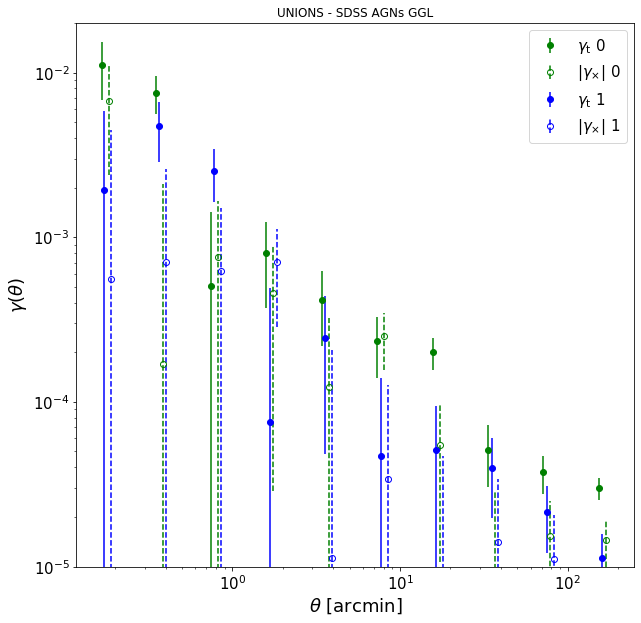

In [98]:
plt.figure(figsize=(10, 10))

fx = [1, 1.05]
fxB = [1.1, 1.15]

col = ['g', 'b']

for idx in range(n_split):
    data_cc = data_cc_list[idx]
    plt.errorbar(
        data_cc['meanr'] * fx[idx],
        np.abs(data_cc['gamT']),
        yerr=data_cc['sigma'],
        fmt='o',
        c=col[idx],
        label=rf'$\gamma_{{\rm t}}$ {idx}'
    )

    eb = plt.errorbar(
        data_cc['meanr'] * fxB[idx],
        np.abs(data_cc['gamX']),
        yerr=data_cc['sigma'],
        fmt='o',
        markerfacecolor='none',
        c=col[idx],
        label=rf'$|\gamma_{{\times}}|$ {idx}'
    )
    eb[-1][0].set_linestyle('--')


plt.xlabel(rf'$\theta$ [{sep_units}]', fontsize=label_size)
plt.ylabel(r'$\gamma(\theta)$', fontsize=label_size)

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-5, 2e-2)
plt.xticks(fontsize = ticks_size)
plt.yticks(fontsize = ticks_size)
plt.legend(fontsize = ticks_size)
plt.title('UNIONS - SDSS AGNs GGL')

_  = plt.savefig(f'{output_path}/{output_cc_base}_log.pdf')